In [187]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
from time import time

In [188]:
def K(X1,X2):
    return 100*np.exp(-np.sum(np.subtract(X1[:,None],X2[None,:])**2/(2*1**2),2))

In [191]:
X = tf.Variable(np.linspace(0,10,100)[:,None],dtype=tf.float32)
Z = tf.Variable(np.linspace(0,10,10)[:,None],dtype=tf.float32)
y = tf.Variable(np.linspace(0,10,100)+np.random.randn(100),dtype=tf.float32)

m = Z.shape[0]

#definition of q(u)
mu = tf.Variable(tf.random.normal([m]))#, name='mu')
scale = tf.Variable(tf.random.normal([m, m]))#, name='scale')

#parameters for p(u)
mu_u = tf.zeros([1,m])
cov_u = tf.Variable(K(Z,Z))
pu = tfd.MultivariateNormalFullCovariance(mu_u,cov_u+np.eye(cov_u.shape[0])*0.01)
invKzz = tf.linalg.inv(K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*0.01)
exact = True
st = time()
for it in range(30):
    with tf.GradientTape() as tape:
        qu = tfd.MultivariateNormalTriL(mu,scale)
        
        qf_mu = K(X,Z) @ invKzz @ mu[:,None]
        #need to solve in a numerically stable manner.
        #only need trace of this... TODO
        qf_cov = K(X,X) - K(X,Z) @ invKzz @ K(Z,X) + K(X,Z)@ invKzz @(scale@tf.transpose(scale))@ invKzz @ K(Z,X)
        
        #py = tfd.MultivariateNormalDiag(qf_mu[:,0],np.ones(X.shape[0],dtype=np.float32))
        #ell = py.log_prob(y) - 0.5* tf.linalg.trace(qf_cov) ###Next thing is to try approximating this -> then replace with our complicated likelihood!
        
        #If we just have a simple Gaussian likelihood:
        if exact:
            alt_ell=0
            for i in range(X.shape[0]):
                alt_ell+=tfd.Normal(qf_mu[i,0],1).log_prob(y[i])-0.5*qf_cov[i,i]
            ell=alt_ell #quicker
        
        #Approximate ell:
        #ellapprx = 0
        #for i in range(X.shape[0]):
        #    dist_f = tfd.Normal(qf_mu[i,0],np.sqrt(qf_cov[i,i]))
        #    f = dist_f.sample(30000)
        #    ellapprx+=np.mean(tfd.Normal(f,1.0).log_prob(y[i]))
        
        if not exact:
            ell = 0
            #ellapprx_using_MC_method = 0
            for i in range(X.shape[0]):
                dist_f = tfd.Normal(qf_mu[i,0],tf.sqrt(qf_cov[i,i]))
                f = dist_f.sample(100)
                ell+=tf.math.reduce_mean(tfd.Normal(f,1.0).log_prob(y[i]))
                ######ell+=tf.math.reduce_mean(tfd.Normal(y[i],1.0).log_prob(f))

                #could use the MC method? Doesn't seem to be an advantage?
                #####ell += tfp.monte_carlo.expectation(f=tfd.Normal(y[i],1.0).log_prob,samples=dist_f.sample(100),log_prob=dist_f.log_prob)
            #print(ell.numpy(),ellapprx.numpy())#,ellapprx2.numpy())

        #######ellapprx = tf.Variable(ellapprx,dtype=tf.float32)
        #print(ell, ellapprx)
        #ell = ellapprx
        #elbo_loss = -( ell - tfd.kl_divergence(qu,pu) )
        elbo_loss = -( ell - tfd.kl_divergence(qu,pu) )
        #approx2_elbo_loss = -( ellapprx2 - tfd.kl_divergence(qu,pu) )
    gradients = tape.gradient(elbo_loss, [mu, scale])
    optimizer.apply_gradients(zip(gradients, [mu, scale]))
    if it%5 == 0: print("%d %0.2f %0.4f %0.0f" % (it,time()-st,(time()-st)/(it+1),elbo_loss.numpy()))#,qf_mu[:,0].numpy(),mu.numpy())
                    

0 0.25 0.2483 2234
5 1.37 0.2281 1079
10 2.51 0.2285 527
15 3.61 0.2259 342
20 4.72 0.2248 335
25 5.79 0.2228 327


In [ ]:
25 11.03 0.4241 264

In [167]:
# Tip: The above didn't work if we used np.sqrt rather than tf.sqrt!
#gradients didn't propagate... but no warning of this...

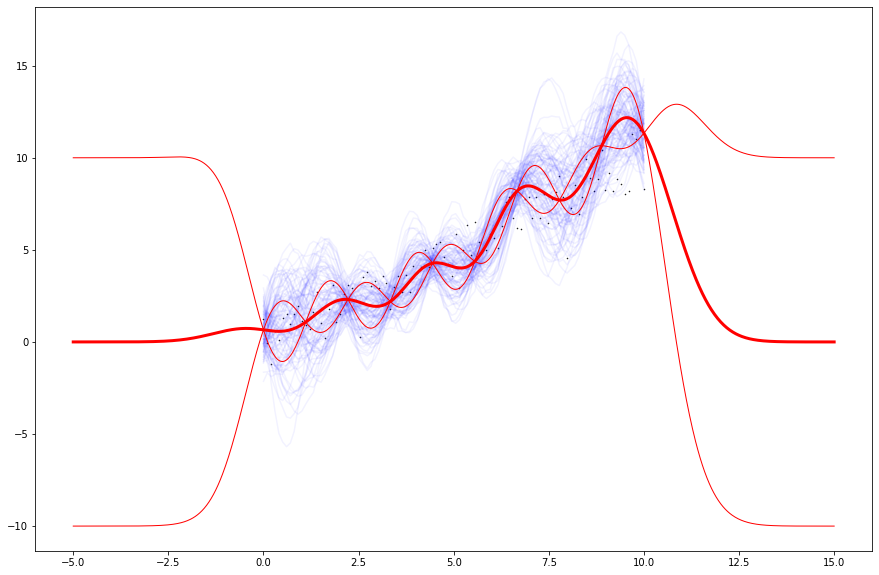

In [192]:
plt.figure(figsize=[15,10])
qf = tfd.MultivariateNormalFullCovariance(qf_mu[:,0],qf_cov+np.eye(qf_cov.shape[0])*0.01)
samps = qf.sample([100]).numpy()
plt.plot(X.numpy()[:,0],y.numpy(),'.k',markersize=1)
plt.plot(X.numpy()[:,0],samps.T,'b-',alpha=0.05);
Xstar = np.linspace(-5,15,1000)[:,None]
invKzz = tf.linalg.inv(K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*0.01)

mean = (K(Xstar,Z) @ invKzz @ mu.numpy()[:,None]).numpy()[:,0]
cov = K(Xstar,Xstar) - K(Xstar,Z) @ np.linalg.inv(K(Z,Z)) @ K(Z,Xstar)
stds = np.sqrt(np.diag(cov))

plt.plot(Xstar,mean,'r-',lw=3);
plt.plot(Xstar,mean+stds,'r-',lw=1);
plt.plot(Xstar,mean-stds,'r-',lw=1);